In [8]:
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime
import util as ut
import training_util as tut
import tensorflow as tf
import os
import json
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
import wandb

BATCH_SIZE = 128
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
# wandb.init(project="Pose", sync_tensorboard=True)

In [9]:
# Load the data into a DataFrame
df = pd.read_csv('ds/distance.csv')
df.drop('filepath', axis=1, inplace=True)

# Shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train, test, and validation sets
train_df = df.iloc[:int(0.9*len(df))]
test_df = df.iloc[int(0.9*len(df)):]

In [10]:
# Convert the DataFrames to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df.drop('pose_type', axis=1), train_df['pose_type']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_df.drop('pose_type', axis=1), test_df['pose_type']))

# Batch the datasets
batch_size = 32
epochs = 300
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# calculate learning rate scheduler
initial_learning_rate = 0.01
final_learning_rate = 0.001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_df.shape[0]/batch_size)+1
print("learning_rate_decay_factor:", learning_rate_decay_factor)
print("steps_per_epoch: ", steps_per_epoch)

learning_rate_decay_factor: 0.9923540961321005
steps_per_epoch:  52


In [11]:
# get model architectures and select last one
models = tut.get_models_and_names(train_df.shape[1],)
model, model_name = models[0][-1], models[1][-1]

# Train the model
history = model.fit(train_dataset, epochs=epochs, workers=4,
                    use_multiprocessing=True, validation_data=test_dataset, verbose=0)


In [14]:
history.history.keys()
# history.history.get('loss')
# history.params

dict_keys(['loss', 'val_loss'])

KeyError: 'y'

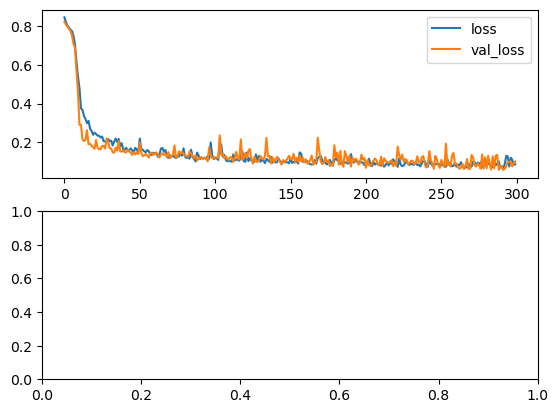

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)

# Create a Seaborn line plot
# sns.lineplot(x=range(0, epochs), y=history.history.get('loss'))

sns.lineplot(x=range(0, epochs), y=history.history.get('loss'), ax=ax1, label='loss')
sns.lineplot(x=range(0, epochs), y=history.history.get('val_loss'), ax=ax1, label='val_loss')

# sns.lineplot(x=range(0, epochs), y=history.history.get('accuracy'), ax=ax2, label='acc')
# sns.lineplot(x=range(0, epochs), y=history.history.get('val_accuracy'), ax=ax2, label='val_acc')

sns.lineplot(x=range(0, epochs), y=history.history.get('accuracy'), ax=ax2, label='accuracy')
sns.lineplot(x=range(0, epochs), y=history.history.get('val_accuracy'), ax=ax2, label='val_accuracy')


ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('accuracy')

# Show the plot
plt.show()

In [15]:
model.save('models/classifier/{}.h5'.format("deep-distance"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 36)                1296      
                                                                 
 dense_19 (Dense)            (None, 128)               4736      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)               